In [4]:
import os
import csv

import cv2
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import tensorflow as tf

## Model definition

In [11]:
### Model Parameters
conv_dropout = 0.4
dense_dropout = 0.5
l2_regularization = 0.001

# l1_regularizer = tf.keras.regularizers.l1(0.01)
l2_regularizer = None #tf.keras.regularizers.l2(l2_regularization)

CROP_UP = 50
CROP_DOWN = 30
final_height = 160 - (CROP_UP + CROP_DOWN)

In [12]:
### Aux functions for batchnorm layers

def conv2d_batch_norm(model, filters, kernel_size, kernel_regularizer=None, activation="relu"):

    model.add(tf.layers.Conv2D(filters, (kernel_size, kernel_size), kernel_regularizer=kernel_regularizer))
    model.add(tf.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation(activation))
    
def dense_batch_norm(model, filters, kernel_regularizer=None, activation="relu"):

    model.add(tf.layers.Dense(filters, kernel_regularizer=kernel_regularizer))
    model.add(tf.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation(activation))

In [13]:
### Actual model
model = tf.keras.Sequential()

model.add(tf.layers.BatchNormalization(input_shape=(final_height, 320, 3)))

conv2d_batch_norm(model, 32, 5, kernel_regularizer=l2_regularizer)
model.add(tf.layers.MaxPooling2D((2, 2), strides=(2,2)))
model.add(tf.layers.Dropout(conv_dropout))

conv2d_batch_norm(model, 32, 3, kernel_regularizer=l2_regularizer)
model.add(tf.layers.MaxPooling2D((2, 2), strides=(2,2)))
model.add(tf.layers.Dropout(conv_dropout))

conv2d_batch_norm(model, 64, 3, kernel_regularizer=l2_regularizer)
model.add(tf.layers.MaxPooling2D((2, 2), strides=(2,2)))
model.add(tf.layers.Dropout(conv_dropout))

conv2d_batch_norm(model, 64, 3, kernel_regularizer=l2_regularizer)
model.add(tf.layers.MaxPooling2D((2, 2), strides=(2,2)))
model.add(tf.layers.Dropout(conv_dropout))

model.add(tf.layers.Flatten())

dense_batch_norm(model, 1024, kernel_regularizer=l2_regularizer)
model.add(tf.layers.Dropout(dense_dropout))

dense_batch_norm(model, 512, kernel_regularizer=l2_regularizer)
model.add(tf.layers.Dropout(dense_dropout))

dense_batch_norm(model, 128, kernel_regularizer=l2_regularizer)
model.add(tf.layers.Dropout(dense_dropout))

model.add(tf.layers.Dense(1))

In [14]:
# create model
model.compile(optimizer=tf.train.AdamOptimizer(0.001),
              loss='mse',       # mean squared error
              metrics=['mae'])  # mean absolute error

## Dataset creation

In [9]:
### folder where the data is
DATASET = "data_mine"

In [18]:
### Load csv as a pandas dataframe
header = ["center", "left", "right", "steering", "throttle", "break", "speed"]
df = pd.read_csv(os.path.join(DATASET, "driving_log.csv"), header=None, names=header)
df.head()

,center,left,right,steering,throttle,break,speed
0,/home/charlie/data/charlie/self-driving-nano/C...,/home/charlie/data/charlie/self-driving-nano/C...,/home/charlie/data/charlie/self-driving-nano/C...,0.0,0.0,0,0.000020
1,/home/charlie/data/charlie/self-driving-nano/C...,/home/charlie/data/charlie/self-driving-nano/C...,/home/charlie/data/charlie/self-driving-nano/C...,0.0,0.0,0,0.000011
2,/home/charlie/data/charlie/self-driving-nano/C...,/home/charlie/data/charlie/self-driving-nano/C...,/home/charlie/data/charlie/self-driving-nano/C...,0.0,0.0,0,0.000011
3,/home/charlie/data/charlie/self-driving-nano/C...,/home/charlie/data/charlie/self-driving-nano/C...,/home/charlie/data/charlie/self-driving-nano/C...,0.0,0.0,0,0.000021
4,/home/charlie/data/charlie/self-driving-nano/C...,/home/charlie/data/charlie/self-driving-nano/C...,/home/charlie/data/charlie/self-driving-nano/C...,0.0,0.0,0,0.000016


In [19]:
def get_image_path(filename):
    return os.path.join(DATASET,"IMG", filename.split("/")[-1])

In [20]:
### Make paths relative to this jupyter notebook
df["center"] = df.center.apply(get_image_path)
df["left"] = df.left.apply(get_image_path)
df["right"] = df.right.apply(get_image_path)
df.head()

,center,left,right,steering,throttle,break,speed
0,data_mine/IMG/center_2019_02_03_21_24_02_332.jpg,data_mine/IMG/left_2019_02_03_21_24_02_332.jpg,data_mine/IMG/right_2019_02_03_21_24_02_332.jpg,0.0,0.0,0,0.000020
1,data_mine/IMG/center_2019_02_03_21_24_02_398.jpg,data_mine/IMG/left_2019_02_03_21_24_02_398.jpg,data_mine/IMG/right_2019_02_03_21_24_02_398.jpg,0.0,0.0,0,0.000011
2,data_mine/IMG/center_2019_02_03_21_24_02_467.jpg,data_mine/IMG/left_2019_02_03_21_24_02_467.jpg,data_mine/IMG/right_2019_02_03_21_24_02_467.jpg,0.0,0.0,0,0.000011
3,data_mine/IMG/center_2019_02_03_21_24_02_536.jpg,data_mine/IMG/left_2019_02_03_21_24_02_536.jpg,data_mine/IMG/right_2019_02_03_21_24_02_536.jpg,0.0,0.0,0,0.000021
4,data_mine/IMG/center_2019_02_03_21_24_02_605.jpg,data_mine/IMG/left_2019_02_03_21_24_02_605.jpg,data_mine/IMG/right_2019_02_03_21_24_02_605.jpg,0.0,0.0,0,0.000016


In [21]:
### Split train and dev set 
train_samples, validation_samples = train_test_split(df, test_size=0.2)

In [22]:
# Get filenames and labels (steerings)
c_filenames = train_samples.center.values
c_labels = train_samples.steering.values

val_filenames = validation_samples.center.values
val_labels = validation_samples.steering.values

In [37]:
# Add side cameras to train set
steer_correction = 0.2

l_filenames = train_samples.left.values
l_labels = train_samples.steering.values + steer_correction

r_filenames = train_samples.right.values
r_labels = train_samples.steering.values - steer_correction

filenames = np.concatenate([c_filenames, l_filenames, r_filenames])
labels = np.concatenate([c_labels, l_labels, r_labels])

In [38]:
# Aux function to crop the images
def get_crop_window(crop_up, crop_down):
    final_height = 160 - (crop_up + crop_down)
    final_width = 320

    return [
        crop_up,
        0,
        final_height,
        final_width,
    ]

In [39]:
# Function that returns the image decoded from jpg and label

def parse_function(filename, label):
    image_string = tf.read_file(filename)

    # Don't use tf.image.decode_image, or the output shape will be undefined
    image = tf.image.decode_jpeg(image_string, channels=3)
    
    image = tf.image.decode_and_crop_jpeg(
            image_string,
            crop_window = get_crop_window(CROP_UP, CROP_DOWN),
            channels = 3
        )

    # This will convert to float values in [0, 1]
#     image = tf.image.convert_image_dtype(image, tf.float32)

#     image = tf.image.resize_images(image, [160, 320])
    return image, label

### Use of TF DataSet API

In [40]:
# Define parameters
BATCH_SIZE = 32
EPOCHS = 2
steps_per_epoch = len(train_samples)*3//BATCH_SIZE

In [41]:
# Create training dataset
dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
dataset = dataset.shuffle(len(filenames))
dataset = dataset.map(parse_function, num_parallel_calls=4)
dataset = dataset.repeat(EPOCHS)
# dataset = dataset.map(train_preprocess, num_parallel_calls=4)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(1)

In [33]:
# Create dev dataset
val_dataset = tf.data.Dataset.from_tensor_slices((val_filenames, val_labels))
val_dataset = val_dataset.map(parse_function, num_parallel_calls=4)
val_dataset = val_dataset.repeat(EPOCHS)
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(1)

In [47]:
# Get image example for trainig
sess = tf.Session()
value = dataset.make_one_shot_iterator().get_next()
x,y = sess.run(value)

(32, 80, 320, 3) 0.2


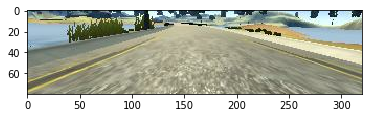

In [48]:
print(x.shape, y[0])
plt.imshow(x[0])

## Training

In [49]:
history = model.fit(dataset,
          epochs=EPOCHS,
          steps_per_epoch=steps_per_epoch,
          validation_data=val_dataset,
          validation_steps=1)

Epoch 1/2
615/615 [==============================] - 192s 312ms/step - loss: 0.0087 - mean_absolute_error: 0.0732 - val_loss: 0.0091 - val_mean_absolute_error: 0.0754
Epoch 2/2
615/615 [==============================] - 194s 316ms/step - loss: 0.0077 - mean_absolute_error: 0.0687 - val_loss: 0.0073 - val_mean_absolute_error: 0.0716


In [22]:
### Save the model
tf.keras.models.save_model(
    model,
    "models/test4"
)